<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20220831.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* customer analysis
* iterator

In [2]:
import pandas as pd 
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes

from datetime import datetime, date, time, timezone, timedelta
import os
import re

from functools import reduce 
from collections import defaultdict, Counter, ChainMap
from itertools import product

# customer analysis

In [3]:
os.listdir()

['.config',
 'test.csv',
 'ecommerce-data.csv',
 'online_retail_II.xlsx',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'KPMG_VI_New_raw_data_update_final.csv',
 'sample_data']

In [4]:
df = pd.read_excel('online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
df.columns = ['_'.join(re.split(r'(?=[A-Z][a-z])', a[0].lower()+a[1:])).lower().replace(' ','_') for a in df.columns]
df.head()

,invoice,stock_code,description,quantity,invoice_date,price,customer_id,country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
df = df[(~df.invoice.astype(str).str.contains('C'))&(df.country == 'United Kingdom')]

In [10]:
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.price
df = df[['customer_id', 'date', 'month', 'rev']].rename(columns = {'customer_id':'id'})
df = df.groupby(['id','date','month'])['rev'].sum().reset_index()
df.head()

,id,date,month,rev
0,12346.0,2009-12-14,2009-12-01,90.0
1,12346.0,2009-12-18,2009-12-01,23.5
2,12346.0,2010-01-04,2010-01-01,45.0
3,12346.0,2010-01-14,2010-01-01,22.5
4,12346.0,2010-01-22,2010-01-01,22.5


In [15]:
df_ = df.assign(week = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]'))
list_npu = df.groupby(['id'])['date'].min().reset_index().rename(columns = {'date':'nru_date'}).reindex(['id','nru_date'], axis = 1)
df_ = pd.merge(df_, list_npu, 'left', 'id')
df_['days'] = (df_['date'] - df_['nru_date']).dt.days
cnt = df_.groupby(['week', 'days'])['id'].count().reset_index().rename(columns = {'id':'pu'})
cnt = cnt.assign(week = cnt['week'].astype(str),
                 ratio = cnt.groupby(['week'])['pu'].apply(lambda x : round(x/x.max()*100,2))
                 )
cnt = pd.melt(cnt, id_vars = ['week','days'], var_name = 'type')
cnt.head()

,week,days,type,value
0,2009-11-30,0,pu,405.0
1,2009-11-30,1,pu,11.0
2,2009-11-30,2,pu,11.0
3,2009-11-30,3,pu,5.0
4,2009-11-30,5,pu,1.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


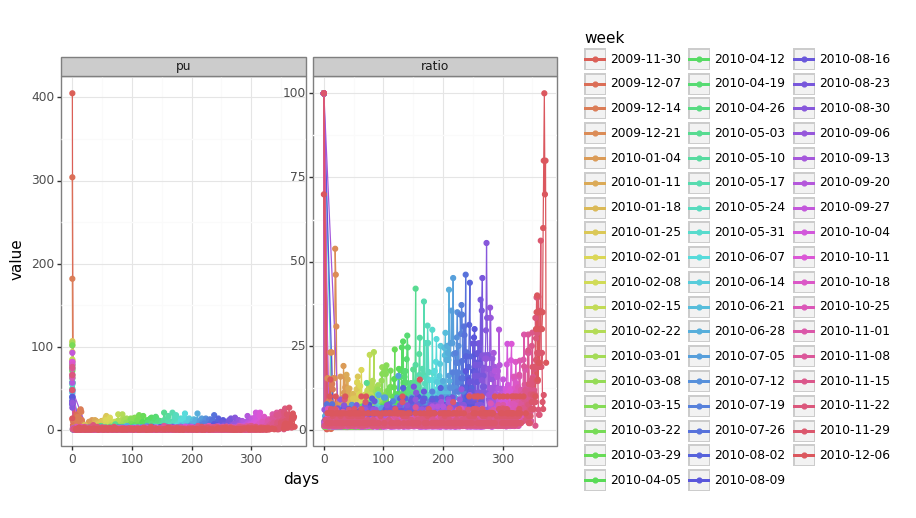

<ggplot: (8750950874797)>

In [16]:
(
    ggplot(cnt, aes('days', 'value', color = 'week')) + 
    gg.geom_line() +
    gg.geom_point() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# iterator

In [18]:
mat = [list('ABC'), list('DEF'), list('GHI')]
a = []
for r, rows in enumerate(mat) :
  for c, letters in enumerate(rows) :
    a.append([r, c, letters])
a

[[0, 0, 'A'],
 [0, 1, 'B'],
 [0, 2, 'C'],
 [1, 0, 'D'],
 [1, 1, 'E'],
 [1, 2, 'F'],
 [2, 0, 'G'],
 [2, 1, 'H'],
 [2, 2, 'I']]

In [19]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [22]:
a = defaultdict(list)
#a = dict()
keys = list(users[0].keys())
for user in users : 
  for key in keys :
    a[key].append(user[key])
a

defaultdict(list,
            {'mail': ['gregorythomas@gmail.com',
              'hintoncynthia@hotmail.com',
              'wwagner@gmail.com',
              'daniel79@gmail.com',
              'ujackson@gmail.com'],
             'name': ['Brett Holland',
              'Madison Martinez',
              'Michael Jenkins',
              'Karen Rodriguez',
              'Amber Rhodes'],
             'sex': ['M', 'F', 'M', 'F', 'F'],
             'age': [73, 29, 51, 32, 42]})

In [24]:
{key : eval(f'reduce(lambda acc, cur : acc + [cur["{key}"]], users, [])') for key in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [26]:
x, y, z = [1000, 10, 1], [900, 10, 1], [100, 10, 1]
[(a, b, c) for a, b, c in product(x, y, z) if a + b + c >= 1000]

[(1000, 900, 100),
 (1000, 900, 10),
 (1000, 900, 1),
 (1000, 10, 100),
 (1000, 10, 10),
 (1000, 10, 1),
 (1000, 1, 100),
 (1000, 1, 10),
 (1000, 1, 1),
 (10, 900, 100),
 (1, 900, 100)]

In [27]:
def add_title_with_name(name) :
  def add_title(func) :
    def wrapper(*args, **kwargs) :
      return name + '\n' + func(*args, **kwargs)
    return wrapper
  return add_title 

def add_title(func) :
  def wrapper(*args, **kwargs) :
    return 'Nayes' + '\n' + func(*args, **kwargs)
  return wrapper 

@add_title_with_name('kokyo')
def get_title(title) :
  return title

@add_title
def get_title2(title) :
  return title 

@add_title
def get_titles(t1, t2) :
  return t1 + t2

In [28]:
print(get_title('hello world!'))
print('-' * 20)
print(get_title2('hello world!'))
print('-' * 20)
print(get_titles('axo', 'axe'))

kokyo
hello world!
--------------------
Nayes
hello world!
--------------------
Nayes
axoaxe
